Welcome to JupyROOT 6.30/02


Info in <TCanvas::Print>: pdf file Plots.pdf has been created
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file Plots.pdf
Info in <TCanvas::Print>: Current canvas 

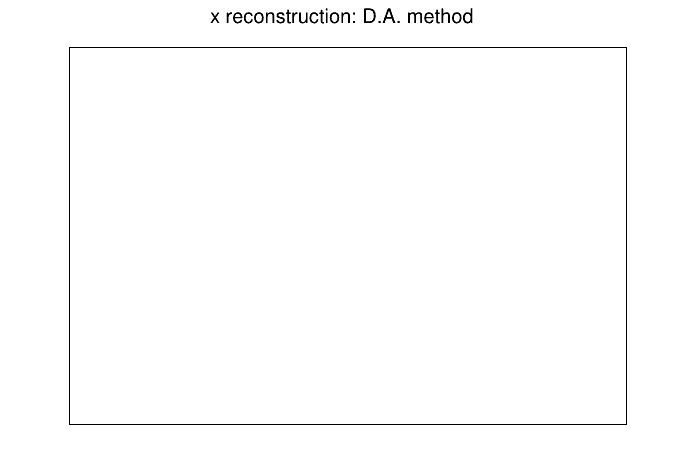

In [1]:
import ROOT
import uproot as up
import numpy as np
import math
import glob
#file_pattern = "/u/home/kspring/eic/eic_elastic/2k_testing/10_100/eicrecon_*.root" # 1 rec proton
#file_pattern = "/scratch/kspring/new_100k_dj/10_100/eicrecon_*.root"
#file_pattern = "/u/home/kspring/eic/eic_elastic/2k_testing/5_41/eicrecon_*.root"
#file_pattern = "/u/home/kspring/eic/eic_elastic/2k_testing/5_41_2/eicrecon_*.root"

# the following are all actually 5x41
#file_pattern = "/scratch/kspring/100k_dj/10_100/eicrecon_*.root"
#file_pattern = "/scratch/kspring/100k_dj/5_100/eicrecon_*.root"   # 1 rec proton
file_pattern = "/scratch/kspring/100k_dj/5_41/eicrecon_*.root"
#file_pattern = "/scratch/kspring/100k_dj/10_275/eicrecon_*.root"   # 2 rec proton
#file_pattern = "/scratch/kspring/100k_dj/18_275/eicrecon_*.root"    # 1 rec proton
file_paths = glob.glob(file_pattern)
root_files = []
f = ROOT.TFile("Elastic_python.root", "RECREATE")
ROOT.gStyle.SetOptStat(0)

h1_elec =ROOT.TH2F("h1_elec", "Scattered electron true momentum vs. polar angle", 100, 0, 180, 100, 0, 10) 
h1_proton =ROOT.TH2F("h1_prot", "Proton true momentum vs. polar angle", 100, 0, 3, 100, 30, 42)
h2_elec =ROOT.TH2F("h2_elec", "Scattered electron reconstructed momentum vs. polar angle", 100, 0, 180, 100, 0, 10)
h2_proton =ROOT.TH2F("h2_prot", "Proton reconstructed momentum vs. polar angle", 100, 0, 180, 100, 0, 100)
h5a = ROOT.TH2D("h5a","Q^{2} reconstruction: electron method",100,0,83,100,0,152)
h5b = ROOT.TH2D("h5b","Q^{2} reconstruction: J.B. method",100,0,83,100,0,7)
h5c = ROOT.TH2D("h5c","Q^{2} reconstruction: D.A. method",100,0,83,100,0,7)
h6a = ROOT.TH2D("h6a","x reconstruction: electron method",100,0,83,100,0,0.05)
h6b = ROOT.TH2D("h6b","x reconstruction: J.B. method",100,0,83,100,0,7)
h6c = ROOT.TH2D("h6c","x reconstruction: D.A. method",100,0,83,100,0,7)

h3a = ROOT.TH1D("h3a","Reconstructed proton and electron #phi balance: Lab frame",100,-600,600)
h3b = ROOT.TH1D("h3b","Reconstructed proton and electron P_{T} balance: Lab frame",100,0,2)
h3c = ROOT.TH1D("h3c","Reconstructed total E - p_{z}: Lab frame",100,5,15)

h4a = ROOT.TH1D("h4a","Reconstructed proton and electron #phi balance: Colinear frame",100,-600,600)
h4b = ROOT.TH1D("h4b","Reconstructed proton and electron P_{T} balance: Colinear frame",100,0,2)
h4c = ROOT.TH1D("h4c","Reconstructed total E - p_{z}: Colinear frame",100,5,15)
# Open each file and add to the list
for path in file_paths:
    root_file = up.open(path)
    root_files.append(root_file)
p_beam_true_list = [] #Proton true beam energy
e_beam_true_list = [] #Electron true beam energy
gen_vec_e_deg_list = []
gen_vec_e_p_list = []
gen_vec_p_deg_list = []
gen_vec_p_p_list = []
rec_vec_e_deg_list = []
rec_vec_e_p_list = []
rec_vec_p_deg_list = []
rec_vec_p_p_list = []
Q2_true_list = []
Q2_elec_list = []
x_elec_list = []
Q2_jb_list = []
x_jb_list = []
            
crossingAngle = -0.025
#change according to energy
e_beam = ROOT.TLorentzVector(0., 0., -10., 10.)
p_beam = ROOT.TLorentzVector(100. * np.sin(crossingAngle), 0, 100. * np.cos(crossingAngle), 100.)
s_cm = 4. * 100. * 100.

# Define a function to apply boost and rotation
def apply_boost(ei, pi, part):
    # Step 1: Find the needed boosts and rotations from the incoming lepton and hadron beams
    # Define the Boost to make beams back-to-back
    #print("Theta before boost:", part.Theta())
    cmBoost = (1. / ei.E()) * ei + (1. / pi.E()) * pi

    boost = ROOT.TLorentzVector(-cmBoost.Px(), -cmBoost.Py(), -cmBoost.Pz(), cmBoost.E())
    b = ROOT.TVector3()
    b = boost.BoostVector()

    boostBack = ROOT.TLorentzVector(0.0, 0.0, cmBoost.Pz(), cmBoost.E())
    bb = ROOT.TVector3()
    bb = boostBack.BoostVector()

    # Boost and rotate the incoming beams to find the proper rotations TLorentzVector
    pi.Boost(b)  # Boost to COM frame
    ei.Boost(b)
    rotAboutY = -1.0 *ROOT.TMath.ATan2(pi.Px(), pi.Pz())  # Rotate to remove x component of beams
    rotAboutX = 1.0 * ROOT.TMath.ATan2(pi.Py(), pi.Pz())  # Rotate to remove y component of beams

    # Step 2: Apply boosts and rotations to the particle 4-vector
    part.Boost(b)
    part.RotateY(rotAboutY)
    part.RotateX(rotAboutX)
    part.Boost(bb)
    #print("Theta after boost:", part.Theta())
    return part

for file in root_files:
    # Example: Print keys (top-level objects) in each file
    events_tree = file["events"]
    gen_status = events_tree["MCParticles.generatorStatus"].array()
    gen_pid = events_tree["MCParticles.PDG"].array() 
    gen_px = events_tree["MCParticles.momentum.x"].array() 
    gen_py = events_tree["MCParticles.momentum.y"].array() 
    gen_pz = events_tree["MCParticles.momentum.z"].array() 
    gen_mass = events_tree["MCParticles.mass"].array() 
    gen_charge = events_tree["MCParticles.charge"].array() 
    gen_vx = events_tree["MCParticles.vertex.x"].array() 
    gen_vy = events_tree["MCParticles.vertex.y"].array() 
    gen_vz = events_tree["MCParticles.vertex.z"].array() 
    rec_pid = events_tree["ReconstructedChargedParticles.PDG"].array() 
    rec_px= events_tree["ReconstructedChargedParticles.momentum.x"].array() 
    rec_py= events_tree[ "ReconstructedChargedParticles.momentum.y"].array() 
    rec_pz= events_tree[ "ReconstructedChargedParticles.momentum.z"].array() 
    rec_mass= events_tree["ReconstructedChargedParticles.mass"].array()

    for event in range(0, len(events_tree)): # Loop over all events  (will see multiple of them for no reason for now
        found_elec = False
        found_prot = False
        for particle in range(0, len(gen_status[event])): # Loop over all generated particles  
            if gen_status[event][particle] == 4 and gen_pid[event][particle] == 11: #Collects electron beam data
                e_beam_true = ROOT.TLorentzVector()
                e_beam_true.SetXYZM(gen_px[event][particle],gen_py[event][particle],gen_pz[event][particle],gen_mass[event][particle])
                e_beam_true_list.append(e_beam_true.Clone()) 
            if gen_status[event][particle] == 4 and gen_pid[event][particle] == 2212: #Collects proton beam data
                p_beam_true = ROOT.TLorentzVector()
                p_beam_true.SetXYZM(gen_px[event][particle],gen_py[event][particle],gen_pz[event][particle],gen_mass[event][particle])
                p_beam_true_list.append(p_beam_true.Clone()) 
            if gen_status[event][particle]==1:
                gen_vec = ROOT.TLorentzVector()
                gen_vertex = ROOT.TVector3()
                gen_vec.SetXYZM(gen_px[event][particle],gen_py[event][particle],gen_pz[event][particle],gen_mass[event][particle])
                gen_vertex.SetXYZ(gen_vx[event][particle],gen_vy[event][particle],gen_vz[event][particle])
                if gen_pid[event][particle] == 11:
                    #print(gen_vec.Theta()* ROOT.TMath.RadToDeg())
                    #gen_vec_e_list.append(gen_vec.Theta()* ROOT.TMath.RadToDeg())
                    gen_vec_e_deg_list.append(gen_vec.Theta()* ROOT.TMath.RadToDeg())
                    gen_vec_e_p_list.append(gen_vec.P())
                    h1_elec.Fill(gen_vec.Theta() * ROOT.TMath.RadToDeg(), gen_vec.P())
                    elec_gen = gen_vec.Clone() 
                if gen_pid[event][particle] == 2212:
                    gen_vec_p_deg_list.append(gen_vec.Theta()* ROOT.TMath.RadToDeg())
                    gen_vec_p_p_list.append(gen_vec.P())
                    h1_proton.Fill(gen_vec.Theta() * ROOT.TMath.RadToDeg(), gen_vec.P())
                Q2_true = -1. * ((e_beam_true - elec_gen).Mag2())

        for particle2 in range(0, len(rec_pid[event])):
            rec_vec = ROOT.TLorentzVector()
            rec_vec_co = ROOT.TLorentzVector()
            rec_vec.SetXYZM(rec_px[event][particle2],rec_py[event][particle2],rec_pz[event][particle2],rec_mass[event][particle2])
            #print(rec_vec.Theta())
            #print(rec_vec.Px(),rec_vec.Py(),rec_vec.Pz(),rec_vec.M())
            rec_vec_co = apply_boost(e_beam, p_beam, rec_vec)
            #print(rec_vec_co.Theta())
            #print("\n")
            if rec_pid[event][particle2] == 11:
                rec_vec_e_deg_list.append(rec_vec.Theta()* ROOT.TMath.RadToDeg())
                rec_vec_e_p_list.append(rec_vec.P())
                elec_rec = rec_vec
                elec_rec_co = rec_vec_co
                found_elec = True
                q_elec = e_beam - elec_rec
                Q2_elec = -1.*q_elec*q_elec
                x_elec = Q2_elec / (2.*p_beam*q_elec)
                h2_elec.Fill(rec_vec.Theta()* ROOT.TMath.RadToDeg(),rec_vec.P())
                
                Q2_true_list.append(Q2_true)
                Q2_elec_list.append(Q2_elec)
                x_elec_list.append(x_elec)
                h5a.Fill(Q2_true,Q2_elec)
                h6a.Fill(Q2_true,x_elec)
            if rec_pid[event][particle2] == 2212:
                rec_vec_p_deg_list.append(rec_vec.Theta()* ROOT.TMath.RadToDeg())
                rec_vec_p_p_list.append(rec_vec.P())
                prot_rec = rec_vec
                prot_rec_co = rec_vec_co
                found_prot = True
                sigma_h = prot_rec_co.E() - prot_rec_co.Pz()
                pt_h = prot_rec_co.Pt()
                y_jb = sigma_h / (2.*e_beam.E())
                Q2_jb = (pt_h*pt_h) / (1. - y_jb)
                x_jb = Q2_jb / (s_cm*y_jb)
                
                h2_proton.Fill(rec_vec.Theta()* ROOT.TMath.RadToDeg(),rec_vec.P())
                
                Q2_true_list.append(Q2_true)
                Q2_jb_list.append(Q2_jb)
                x_jb_list.append(x_jb)
                h5b.Fill(Q2_true,Q2_jb)
                h6b.Fill(Q2_true,x_jb)
                
            if found_elec and found_prot:
                tan_tpo2 = math.tan( prot_rec_co.Theta()/2. )
                tan_teo2 = math.tan( elec_rec_co.Theta()/2. )
                cot_teo2 = 1./tan_teo2
                y_da = (tan_tpo2) / (tan_tpo2 + tan_teo2)
                Q2_da = 4. * pow(e_beam.E(),2) * (cot_teo2) / (tan_tpo2 + tan_teo2)
                x_da = Q2_da / (s_cm*y_da)
                
                h5c.Fill(Q2_true,Q2_da)
                h6c.Fill(Q2_true,x_da)
            if found_elec and found_prot:
                phi_diff = abs(prot_rec.Phi() - elec_rec.Phi()) - math.pi
                Empz_tot = prot_rec.E() - prot_rec.Pz() + elec_rec.E() - elec_rec.Pz()
                h3a.Fill(1000.*phi_diff)
                h3b.Fill(prot_rec.Pt() / elec_rec.Pt())
                h3c.Fill(Empz_tot)

                phi_diff_co = abs(prot_rec_co.Phi() - elec_rec_co.Phi()) - math.pi
                Empz_tot_co = prot_rec_co.E() - prot_rec_co.Pz() + elec_rec_co.E() - elec_rec_co.Pz()
                h4a.Fill(1000.*phi_diff_co)
                h4b.Fill(prot_rec_co.Pt() / elec_rec_co.Pt())
                h4c.Fill(Empz_tot_co)
                
c1a = ROOT.TCanvas("c1a")
h1_elec.Draw("COLZ")
tex1 = ROOT.TLatex()
tex1.SetTextSize(0.035)
tex1.DrawLatex(90,7.1,"Elastic generator: e + p #rightarrow e + p")
tex1.DrawLatex(90,6.60,"10x100 GeV: Q^{2}_{gen.} < 5 GeV^{2}/c^{2}")
tex1.DrawLatex(90,6.20,"Beam-effects afterburner applied")
tex1.DrawLatex(90,5.80,"100k events generated: #intL = ? fb^{-1}")

c1b = ROOT.TCanvas("c1b")
h1_proton.Draw("COLZ")

c2a = ROOT.TCanvas("c2a")
h2_elec.Draw("COLZ")

c2b = ROOT.TCanvas("c2b")
h2_proton.Draw("COLZ")

c3a = ROOT.TCanvas("c3a")
h3a.Draw("")

c3b = ROOT.TCanvas("c3b")
h3b.Draw("")
    
c3c = ROOT.TCanvas("c3c")
h3c.Draw("")

c4a = ROOT.TCanvas("c4a")
h4a.Draw("")

c4b = ROOT.TCanvas("c4b")
h4b.Draw("")

c4c = ROOT.TCanvas("c4c")
h4c.Draw("")

c5a = ROOT.TCanvas("c5a")
h5a.Draw("COLZ")

c5b = ROOT.TCanvas("c5b")
h5b.Draw("COLZ")

c5c = ROOT.TCanvas("c5c")
h5c.Draw("COLZ")

c6a = ROOT.TCanvas("c6a")
h6a.Draw("COLZ")

c6b = ROOT.TCanvas("c6b")
h6b.Draw("COLZ")

c6c = ROOT.TCanvas("c6c")
h6c.Draw("COLZ")
    
c1a.Print("Plots.pdf[")
c1a.Print("Plots.pdf")
c1b.Print("Plots.pdf")
c2a.Print("Plots.pdf")
c2b.Print("Plots.pdf")
c3a.Print("Plots.pdf")
c3b.Print("Plots.pdf")
c3c.Print("Plots.pdf")
c4a.Print("Plots.pdf")
c4b.Print("Plots.pdf")
c4c.Print("Plots.pdf")
c5a.Print("Plots.pdf")
c5b.Print("Plots.pdf")
c5c.Print("Plots.pdf")
c6a.Print("Plots.pdf")
c6b.Print("Plots.pdf")
c6c.Print("Plots.pdf")
c6c.Print("Plots.pdf]")
f.Write()
f.Close()
        


 

In [2]:
#p_beam_true_list #Proton true beam energy
#e_beam_true_list #Electron true beam energy
#gen_vec_e_deg_list = []
#gen_vec_e_p_list
#gen_vec_p_deg_list = []
#gen_vec_p_p_list 
#rec_vec_e_deg_list = []
#rec_vec_e_p_list = []
#rec_vec_p_deg_list = []
#rec_vec_p_p_list
Q2_true_list
#Q2_elec_list 
#x_elec_list
#Q2_jb_list
#x_jb_list
            

[0.00043382104915359936,
 1.11811049342327,
 1.630531409222158,
 1.207092153112658,
 9.036011846982888,
 3.2857836992725247,
 3.583704306317408,
 1.2853369525696197,
 4.721967769178587,
 2.0944419543950907,
 1.8945856584809633,
 2.3642624114503565,
 1.1118771305400657,
 1.0216821791183595,
 1.0851249578489641,
 2.3379710431689986,
 1.365114111121791,
 2.898660905838362,
 1.4117136075097108,
 8.049536411097083,
 1.1488427323235655,
 1.8966299615953588,
 2.0300438521726534,
 14.491426068876303,
 21.50254220346188,
 1.1479916110460344,
 1.0461953248318672,
 2.0930471095459584,
 8.987988713847795,
 5.4024322855497005,
 1.0401517935683913,
 1.2142441409179598,
 1.133181204128137,
 5.4502812235648435,
 1.3209589471490482,
 1.339029886281839,
 2.2876757605255484,
 1.0501449963580216,
 1.5008053507304717,
 2.62924665548422,
 1.3266397734133188,
 1.5649035277757717,
 1.9303602072246662,
 1.0072214361727851,
 1.2244303238007284,
 1.1596748289135022,
 3.643711911368939,
 1.4382963657961119,
 1.46